<a href="https://colab.research.google.com/github/Ali-Alameer/Deep-Learning/blob/main/week6_tensorflowhub_with_your_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Hub 


[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This workshop demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`.
1. Use an image classification model from TensorFlow Hub.
1. Do simple transfer learning to fine-tune a model for your own image classes.

## Setup

In [37]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## An ImageNet classifier

You'll start by using a classifier model pre-trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) benchmark dataset—no initial training required!

### Download the classifier

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any <a href="https://tfhub.dev/s?q=tf2&module-type=image-classification/" class="external">compatible image classifier model</a> from TensorFlow Hub will work here, including the examples provided in the drop-down below.

In [38]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [39]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

Download a single image to try the model on:

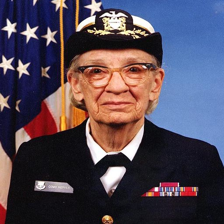

In [40]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [41]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [42]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 244ms/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [43]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

### Decode the predictions

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

In [44]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the unversity of Salford buildings dataset:

In [45]:
!git clone https://github.com/Temmytope-seun/aslNumbers.git

fatal: destination path 'aslNumbers' already exists and is not an empty directory.


In [46]:
import os
HOME = os.getcwd()
print(HOME)
data_dir = os.path.join(HOME, 'aslNumbers/aslNumbers')

/home/sup194/Downloads


If you have your dataset collected by yourself, upload to your google drive and use the below code:

In [47]:
#from google.colab import drive
#drive.mount('/content/drive')
#import pathlib
#data_dir = "/content/drive/MyDrive/dataset/"
#data_dir = pathlib.Path(data_dir)

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [48]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [49]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 408 files belonging to 9 classes.
Using 327 files for training.


In [50]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 408 files belonging to 9 classes.
Using 81 files for validation.


In [51]:
train_ds = train_dataset
val_ds = validation_dataset

See classes of the dataset:

In [52]:
class_names = np.array(train_ds.class_names)
print(class_names)

['1 One' '2 Two' '3 Three' '4 Four' '5 Five' '6 Six' '7 Seven' '8 Eight'
 '9 Nine']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [53]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [54]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2024-12-06 14:25:08.629280: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [56]:
result_batch = classifier.predict(train_ds)

11/11 [==============================] - 2s 120ms/step


In [57]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Band Aid', 'Band Aid', 'Band Aid', 'Band Aid', 'Band Aid',
       'nipple', 'Band Aid', 'cowboy boot', 'Band Aid', 'nipple',
       'spatula', 'Band Aid', 'Band Aid', 'handkerchief', 'Band Aid',
       'ballpoint', 'prison', 'ballpoint', 'Band Aid', 'Band Aid',
       'Band Aid', 'Band Aid', 'Band Aid', 'Band Aid', 'Band Aid',
       'Band Aid', 'window shade', 'Band Aid', 'Band Aid', 'screwdriver',
       'Band Aid', 'spatula', 'Band Aid', 'letter opener', 'pick',
       'Band Aid', 'ballpoint', 'Band Aid', 'spatula', 'Band Aid',
       'Band Aid', 'letter opener', 'can opener', 'nipple', 'nipple',
       'Band Aid', 'Band Aid', 'Band Aid', 'Band Aid', 'letter opener',
       'Band Aid', 'Band Aid', 'spatula', 'Band Aid', 'Band Aid',
       'computer keyboard', 'Band Aid', 'mortar', 'spatula', 'Band Aid',
       'Band Aid', 'knot', 'nipple', 'Band Aid', 'Band Aid', 'Band Aid',
       'Band Aid', 'Band Aid', 'notebook', 'spatula', 'Band Aid',
       'Band Aid', 'rubber eraser',

Check how these predictions line up with the images:

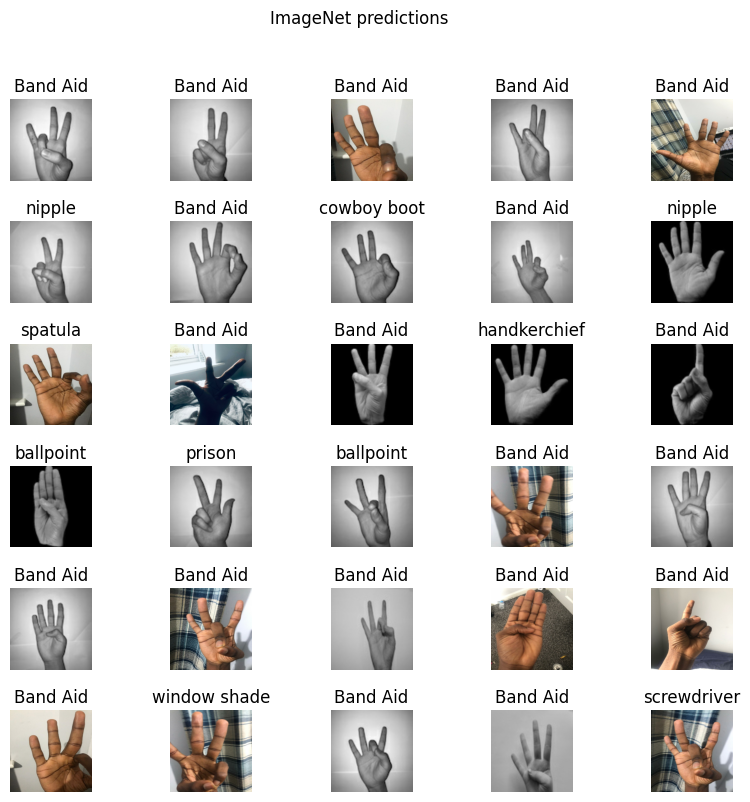

In [58]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The results are far from perfect, but reasonable considering that these are not

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [59]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [60]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [61]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [62]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 9)                 11529     
                                                                 
Total params: 2269513 (8.66 MB)
Trainable params: 11529 (45.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [63]:
predictions = model(image_batch)

In [64]:
predictions.shape

TensorShape([32, 9])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [65]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [66]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
11/11 [==============================] - 4s 263ms/step - loss: 2.1849 - acc: 0.1437 - val_loss: 2.0151 - val_acc: 0.2840
Epoch 2/10
11/11 [==============================] - 2s 223ms/step - loss: 1.6143 - acc: 0.4832 - val_loss: 1.6613 - val_acc: 0.5062
Epoch 3/10
11/11 [==============================] - 2s 216ms/step - loss: 1.2469 - acc: 0.6820 - val_loss: 1.4562 - val_acc: 0.4938
Epoch 4/10
11/11 [==============================] - 2s 225ms/step - loss: 1.0139 - acc: 0.7859 - val_loss: 1.2787 - val_acc: 0.6296
Epoch 5/10
11/11 [==============================] - 2s 223ms/step - loss: 0.8458 - acc: 0.8563 - val_loss: 1.1589 - val_acc: 0.6667
Epoch 6/10
11/11 [==============================] - 2s 220ms/step - loss: 0.7217 - acc: 0.8899 - val_loss: 1.0661 - val_acc: 0.7407
Epoch 7/10
11/11 [==============================] - 2s 226ms/step - loss: 0.6283 - acc: 0.9174 - val_loss: 0.9917 - val_acc: 0.7654
Epoch 8/10
11/11 [==============================] - 2s 217ms/step - loss: 0.

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [67]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 9376), started 0:14:58 ago. (Use '!kill 9376' to kill it.)

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [68]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 359ms/step
['7 Seven' '2 Two' '9 Nine' '7 Seven' '5 Five' '2 Two' '9 Nine' '9 Nine'
 '9 Nine' '5 Five' '9 Nine' '3 Three' '6 Six' '5 Five' '1 One' '4 Four'
 '3 Three' '7 Seven' '6 Six' '4 Four' '4 Four' '8 Eight' '8 Eight'
 '4 Four' '1 One' '9 Nine' '6 Six' '8 Eight' '6 Six' '8 Eight' '1 One'
 '3 Three']


Plot the model predictions:

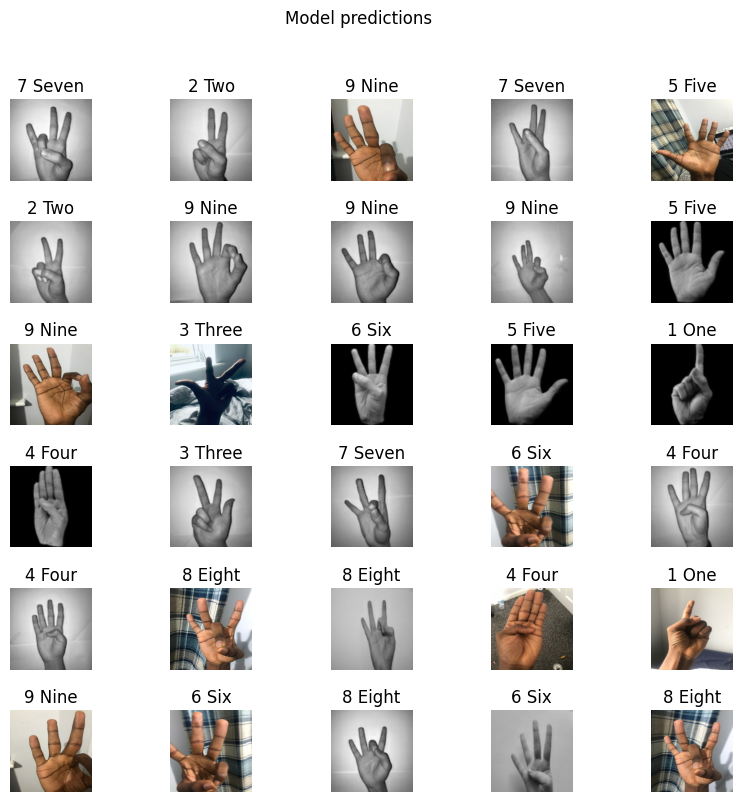

In [69]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [70]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1733495139/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1733495139/assets


'/tmp/saved_models/1733495139'

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [71]:
reloaded = tf.keras.models.load_model(export_path)

In [72]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 0s 333ms/step


In [73]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [74]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['7 Seven' '2 Two' '9 Nine' '7 Seven' '5 Five' '2 Two' '9 Nine' '9 Nine'
 '9 Nine' '5 Five' '9 Nine' '3 Three' '6 Six' '5 Five' '1 One' '4 Four'
 '3 Three' '7 Seven' '6 Six' '4 Four' '4 Four' '8 Eight' '8 Eight'
 '4 Four' '1 One' '9 Nine' '6 Six' '8 Eight' '6 Six' '8 Eight' '1 One'
 '3 Three']


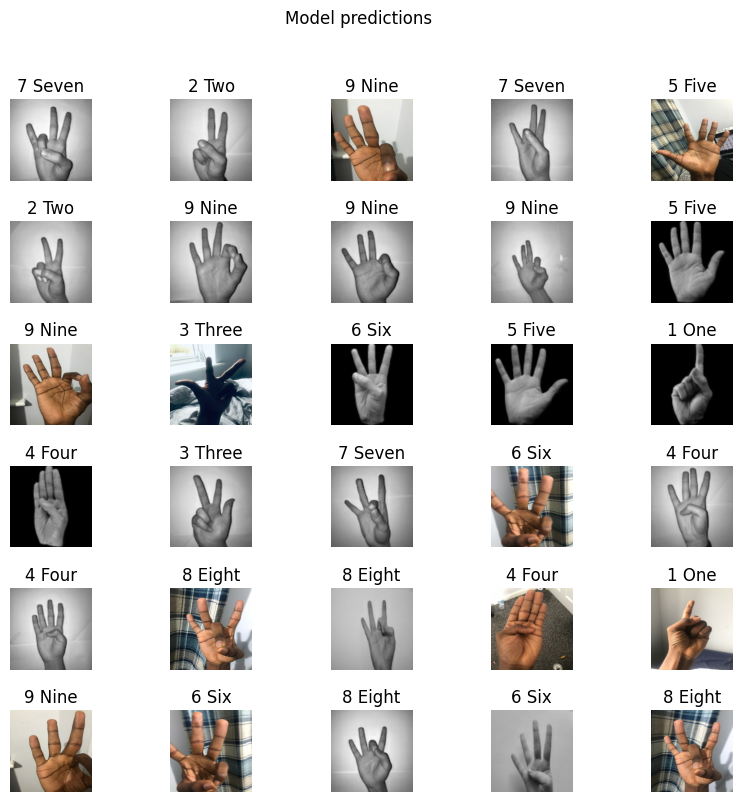

In [75]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).


In [76]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
     

3/3 [==============================] - 0s 96ms/step - loss: 0.8493 - acc: 0.8025
Validation Loss: 0.8493319153785706
Validation Accuracy: 0.8024691343307495


1/1 [==============================] - 0s 273ms/step


<Figure size 800x600 with 0 Axes>

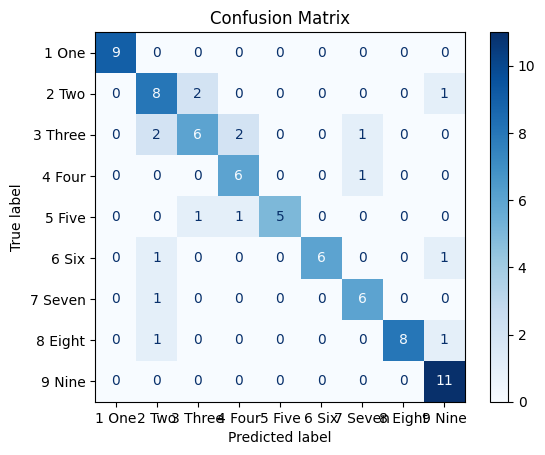

In [77]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

true_labels = []
predictions = []

for images, labels in val_ds:
    preds = model.predict(images)
    true_labels.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=-1))

cm = confusion_matrix(true_labels, predictions)
class_names = class_names


plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [78]:
import matplotlib.pyplot as plt

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy using ImageNet_v2 pretrained model')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss using ImageNet_v2 pretrained model')
plt.legend()


plt.tight_layout()
plt.show()

In [79]:
#Classification report

from sklearn.metrics import classification_report

true_labels = []
predictions = []

for images, labels in val_ds:
    preds = model.predict(images)
    true_labels.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=-1))

# Generate a classification report
class_names = class_names
report = classification_report(true_labels, predictions, target_names=class_names)
print("Classification Report:")
print(report)

1/1 [==============================] - 0s 82ms/step
Classification Report:
              precision    recall  f1-score   support

       1 One       1.00      1.00      1.00         9
       2 Two       0.62      0.73      0.67        11
     3 Three       0.67      0.55      0.60        11
      4 Four       0.67      0.86      0.75         7
      5 Five       1.00      0.71      0.83         7
       6 Six       1.00      0.75      0.86         8
     7 Seven       0.75      0.86      0.80         7
     8 Eight       1.00      0.80      0.89        10
      9 Nine       0.79      1.00      0.88        11

    accuracy                           0.80        81
   macro avg       0.83      0.81      0.81        81
weighted avg       0.82      0.80      0.80        81



In [ ]:
### With InceptionV3

In [82]:
feature_extractor_layer2 = hub.KerasLayer(
    inception_v3,
    input_shape=(224, 224, 3),
    trainable=False
)
  

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

num_classes = len(class_names)

model_2 = Sequential([
    feature_extractor_layer2,  # Pre-trained Inception V3 feature extractor
    layers.Dense(num_classes, activation='softmax')
])

model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 21821225 (83.24 MB)
Trainable params: 18441 (72.04 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [84]:


model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
     

history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1
)

     


Epoch 1/15
11/11 [==============================] - 7s 422ms/step - loss: 2.3769 - accuracy: 0.1560 - val_loss: 2.0676 - val_accuracy: 0.2716
Epoch 2/15
11/11 [==============================] - 4s 382ms/step - loss: 1.7036 - accuracy: 0.4037 - val_loss: 1.6755 - val_accuracy: 0.4568
Epoch 3/15
11/11 [==============================] - 4s 373ms/step - loss: 1.2580 - accuracy: 0.6116 - val_loss: 1.4625 - val_accuracy: 0.5185
Epoch 4/15
11/11 [==============================] - 4s 372ms/step - loss: 1.0426 - accuracy: 0.7125 - val_loss: 1.3355 - val_accuracy: 0.5062
Epoch 5/15
11/11 [==============================] - 4s 374ms/step - loss: 0.8807 - accuracy: 0.7829 - val_loss: 1.2315 - val_accuracy: 0.5679
Epoch 6/15
11/11 [==============================] - 4s 370ms/step - loss: 0.7598 - accuracy: 0.8410 - val_loss: 1.1636 - val_accuracy: 0.5802
Epoch 7/15
11/11 [==============================] - 4s 375ms/step - loss: 0.6690 - accuracy: 0.8563 - val_loss: 1.1103 - val_accuracy: 0.5926
Epoch 

In [85]:
loss, accuracy = model_2.evaluate(val_ds)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

3/3 [==============================] - 1s 261ms/step - loss: 0.9366 - accuracy: 0.6543
Validation Loss: 0.9366010427474976
Validation Accuracy: 0.654321014881134


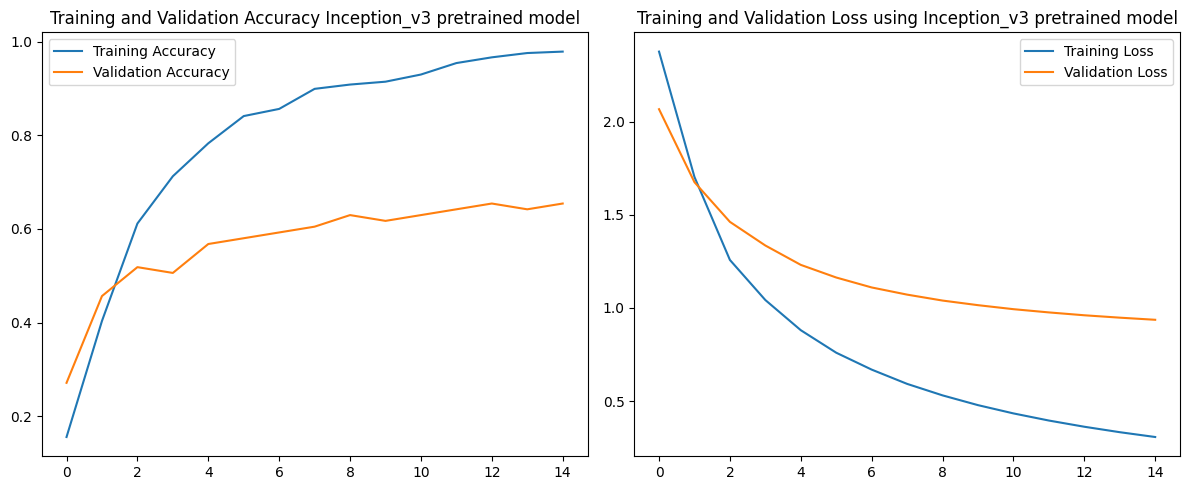

In [86]:
import matplotlib.pyplot as plt

accuracy = history_2.history['accuracy']
val_accuracy = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(len(accuracy))

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Inception_v3 pretrained model')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss using Inception_v3 pretrained model')
plt.legend()


plt.tight_layout()
plt.show()

In [87]:
#Saving inception trained model

t = time.time()

export_path_2 = "/tmp/saved_models/{}".format(int(t))
model_2.save(export_path_2)

export_path_2

INFO:tensorflow:Assets written to: /tmp/saved_models/1733495446/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1733495446/assets


'/tmp/saved_models/1733495446'

In [88]:
reloaded_2 = tf.keras.models.load_model(export_path_2)

In [89]:

result_batch_2 = model_2.predict(image_batch)
reloaded_result_batch_2 = reloaded_2.predict(image_batch)

1/1 [==============================] - 1s 645ms/step


In [90]:
abs(reloaded_result_batch_2 - result_batch_2).max()

0.0

In [91]:
reloaded_predicted_id_2 = tf.math.argmax(reloaded_result_batch_2, axis=-1)
reloaded_predicted_label_batch_2 = class_names[reloaded_predicted_id_2]
print(reloaded_predicted_label_batch_2)

['7 Seven' '2 Two' '9 Nine' '7 Seven' '5 Five' '2 Two' '9 Nine' '9 Nine'
 '9 Nine' '5 Five' '9 Nine' '3 Three' '6 Six' '5 Five' '1 One' '4 Four'
 '3 Three' '8 Eight' '6 Six' '4 Four' '4 Four' '8 Eight' '8 Eight'
 '4 Four' '1 One' '9 Nine' '6 Six' '8 Eight' '4 Four' '8 Eight' '1 One'
 '3 Three']


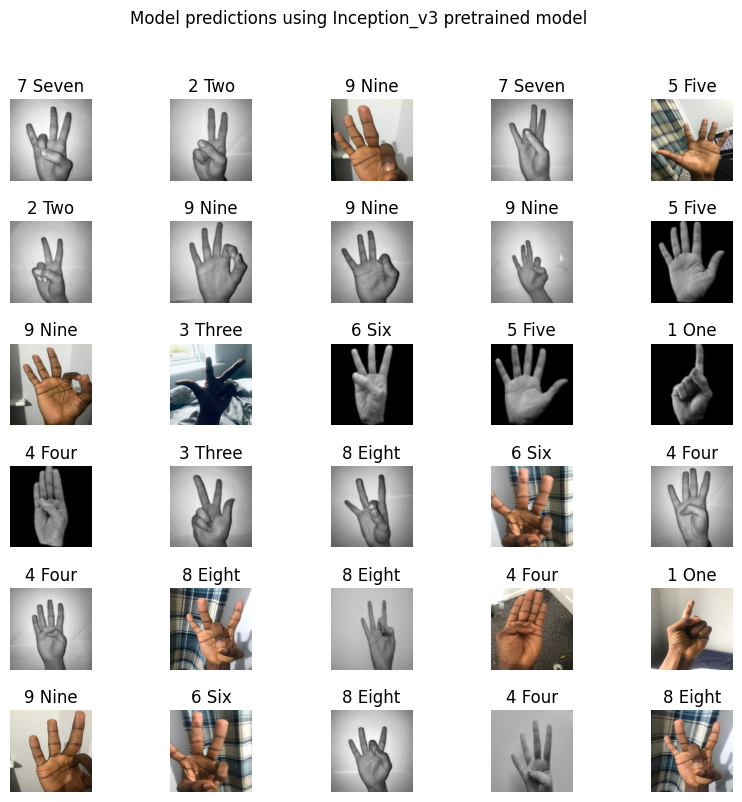

In [92]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch_2[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions using Inception_v3 pretrained model")

1/1 [==============================] - 1s 508ms/step


<Figure size 800x600 with 0 Axes>

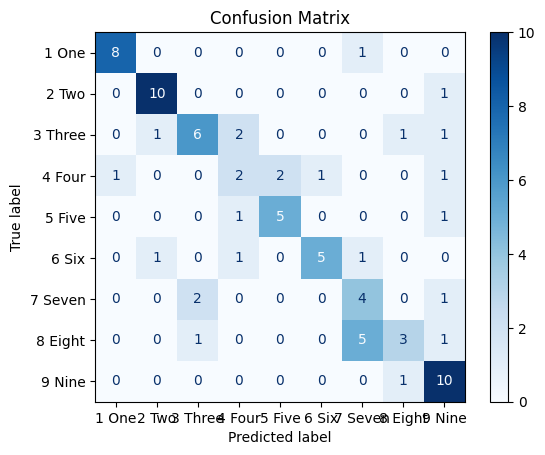

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

true_labels = []
predictions = []

for images, labels in val_ds:
    preds = model_2.predict(images)
    true_labels.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=-1))

cm = confusion_matrix(true_labels, predictions)
class_names = class_names


plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [94]:
#Classification report

from sklearn.metrics import classification_report

true_labels = []
predictions = []

for images, labels in val_ds:
    preds = model_2.predict(images)
    true_labels.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=-1))

# Generate a classification report
class_names = class_names
report = classification_report(true_labels, predictions, target_names=class_names)
print("Classification Report:")
print(report)

1/1 [==============================] - 0s 188ms/step
Classification Report:
              precision    recall  f1-score   support

       1 One       0.89      0.89      0.89         9
       2 Two       0.83      0.91      0.87        11
     3 Three       0.67      0.55      0.60        11
      4 Four       0.33      0.29      0.31         7
      5 Five       0.71      0.71      0.71         7
       6 Six       0.83      0.62      0.71         8
     7 Seven       0.36      0.57      0.44         7
     8 Eight       0.60      0.30      0.40        10
      9 Nine       0.62      0.91      0.74        11

    accuracy                           0.65        81
   macro avg       0.65      0.64      0.63        81
weighted avg       0.67      0.65      0.65        81

